In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Check for GPU
device = torch.device('cpu')
print(f'Using device: {device}')

Using device: cpu


## Data Preprocessing

We'll apply normalization and data augmentation to improve model generalization.

In [18]:
# Define transformations
# For training we will use normalization + augmentation
train_transform = transforms.Compose([
    transforms.RandomRotation(10),  # Random rotation for robustness (augmentation)
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Random translation (augmentation)
    transforms.ToTensor(), # Convert to tensor (normalization will be applied after)
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST mean and std (normalization)
])

# For testing we use only normalization
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load datasets with transformations from above
train_dataset = MNIST(root='./data', train=True, download=True, transform=train_transform)
test_dataset = MNIST(root='./data', train=False, download=True, transform=test_transform)

# Split training data into train and validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))

# Print dataset sizes for verification
print(f"Train set: {len(train_dataset)} samples")
print(f"Validation set: {len(val_dataset)} samples")
print(f"Test set: {len(test_dataset)} samples")

# Create data loaders
batch_size = 64  # Will be tuned later (initial value)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

Train set: 48000 samples
Validation set: 12000 samples
Test set: 10000 samples


## CNN Model Architecture

We'll implement a modern CNN architecture with:
- Convolutional layers with different kernel sizes and strides
- Batch normalization for stable training
- Max pooling for downsampling
- Dropout for regularization
- Global average pooling before the final classifier

In [19]:
class MyCNN(nn.Module):
    def __init__(self, num_classes=10, dropout_rate=0.5):
        super(MyCNN, self).__init__()

        # First convolutional block
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)  # 28x28 -> 28x28
        self.bn1 = nn.BatchNorm2d(32) # Batch normalization
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)  # 28x28 -> 28x28
        self.bn2 = nn.BatchNorm2d(32) # Batch normalization
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # 28x28 -> 14x14 (max pooling)
        self.dropout1 = nn.Dropout2d(dropout_rate) # Dropout for regularization

        # Second convolutional block
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)  # 14x14 -> 14x14
        self.bn3 = nn.BatchNorm2d(64) # Batch normalization
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)  # 14x14 -> 14x14
        self.bn4 = nn.BatchNorm2d(64) # Batch normalization
        self.pool2 = nn.AdaptiveAvgPool2d((1, 1))  # Global average pooling: 14x14 -> 1x1
        self.dropout2 = nn.Dropout(dropout_rate)

        # Fully connected layers (classifier)
        self.fc1 = nn.Linear(64, 128) # From 64 (after global avg pool) to 128
        self.bn_fc1 = nn.BatchNorm1d(128) # Batch normalization
        self.dropout_fc = nn.Dropout(dropout_rate) # Dropout for regularization
        self.fc2 = nn.Linear(128, num_classes) # Final output layer

    def forward(self, x):
        # First block
        x = torch.relu(self.bn1(self.conv1(x)))
        x = torch.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        x = self.dropout1(x)

        # Second block
        x = torch.relu(self.bn3(self.conv3(x)))
        x = torch.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        x = x.view(x.size(0), -1)  # Flatten for fully connected layer
        x = self.dropout2(x)

        # Classifier
        x = torch.relu(self.bn_fc1(self.fc1(x)))
        x = self.dropout_fc(x)
        x = self.fc2(x)
        return x

## Hyperparameter Tuning with Random Search

We'll perform random search over key hyperparameters to find the optimal configuration. This is more efficient than grid search for high-dimensional spaces.

In [20]:
# Training and validation functions
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def validate_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

# Full training loop with early stopping
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, patience, device):
    best_val_acc = 0.0
    best_model_state = None
    patience_counter = 0
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    
    # Training loop with early stopping 
    for epoch in range(num_epochs):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
        scheduler.step(val_loss)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                break
    if best_model_state:
        model.load_state_dict(best_model_state)
    return train_losses, val_losses, train_accs, val_accs

In [21]:
def random_search(num_trials=3, max_epochs=5):
    best_accuracy = 0.0
    best_params = None
    best_model_state = None

    # Define hyperparameter ranges
    lr_range = [1e-3, 1e-2]
    batch_size_range = [32,64]
    dropout_range = [0.4, 0.5]
    weight_decay = 1e-4
    optimizer = 'Adam'
    scheduler = 'ReduceLROnPlateau'
    patience = 5
    results = []

    for trial in range(num_trials):
        # Randomly sample hyperparameters
        lr = random.choice(lr_range)
        batch_size = random.choice(batch_size_range)
        dropout_rate = random.choice(dropout_range)
      
        # Create data loaders with current batch size
        train_loader_trial = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
        val_loader_trial = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
        # Initialize model
        model = MyCNN(dropout_rate=dropout_rate).to(device)
        # Loss
        criterion = nn.CrossEntropyLoss()
        # Optimizer
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        # Scheduler
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=False)
        
        # Train for a few epochs
        train_losses, val_losses, train_accs, val_accs = train_model(
            model, train_loader_trial, val_loader_trial, criterion, optimizer, scheduler,
            num_epochs=max_epochs, patience=patience, device=device
        )
        # Get best validation accuracy
        max_val_acc = max(val_accs)
        results.append({
            'trial': trial+1,
            'lr': lr,
            'batch_size': batch_size,
            'dropout_rate': dropout_rate,
            'weight_decay': weight_decay,
            'optimizer': 'Adam',
            'scheduler': 'ReduceLROnPlateau',
            'patience': patience,
            'val_accuracy': max_val_acc
        })
        if max_val_acc > best_accuracy:
            best_accuracy = max_val_acc
            best_params = {
                'lr': lr,
                'batch_size': batch_size,
                'dropout_rate': dropout_rate,
                'weight_decay': weight_decay,
                'optimizer': optimizer,
                'scheduler': scheduler,
                'patience': patience
            }
            best_model_state = model.state_dict()
    print(f"Best hyperparameters: {best_params}")
    print(f"Best validation accuracy: {best_accuracy:.4f}")
    return best_params, best_model_state, results

# Run random search
best_params, best_model_state, tuning_results = random_search(num_trials=3, max_epochs=5)

Best hyperparameters: {'lr': 0.001, 'batch_size': 32, 'dropout_rate': 0.4, 'weight_decay': 0.0001, 'optimizer': Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0.0001
), 'scheduler': <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x0000014BCE24FEB0>, 'patience': 5}
Best validation accuracy: 0.9825


## Final Model Training

Train the model with the best hyperparameters found from random search.

Training final model...


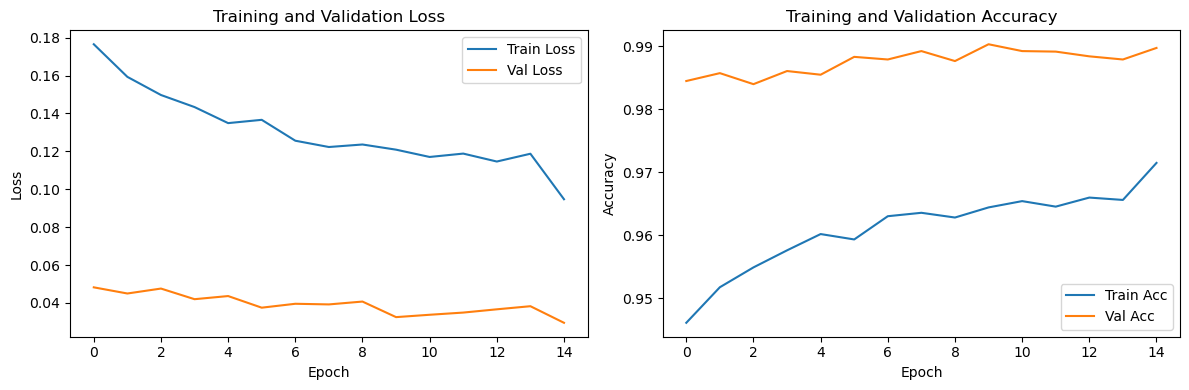

In [22]:
# Train final model with best hyperparameters
final_model = MyCNN(dropout_rate=best_params['dropout_rate']).to(device)
if best_model_state:
    final_model.load_state_dict(best_model_state)

# Create data loaders with best batch size
final_train_loader = DataLoader(train_dataset, batch_size=best_params['batch_size'], shuffle=True, num_workers=0)
final_val_loader = DataLoader(val_dataset, batch_size=best_params['batch_size'], shuffle=False, num_workers=0)
final_test_loader = DataLoader(test_dataset, batch_size=best_params['batch_size'], shuffle=False, num_workers=0)

# Loss, optimizer, scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(final_model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

# Train the final model
print("Training final model...")
train_losses, val_losses, train_accs, val_accs = train_model(
    final_model, final_train_loader, final_val_loader, criterion, optimizer, scheduler,
    num_epochs=20, patience=5, device=device
)

# Plot training curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.tight_layout()
plt.show()

## Model Evaluation

Evaluate the trained model on the test set and analyze performance.

Test Accuracy: 0.9937

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       1.00      0.99      0.99      1135
           2       0.99      1.00      1.00      1032
           3       0.99      1.00      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       1.00      0.99      0.99       958
           7       0.99      1.00      0.99      1028
           8       1.00      0.99      1.00       974
           9       0.99      1.00      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



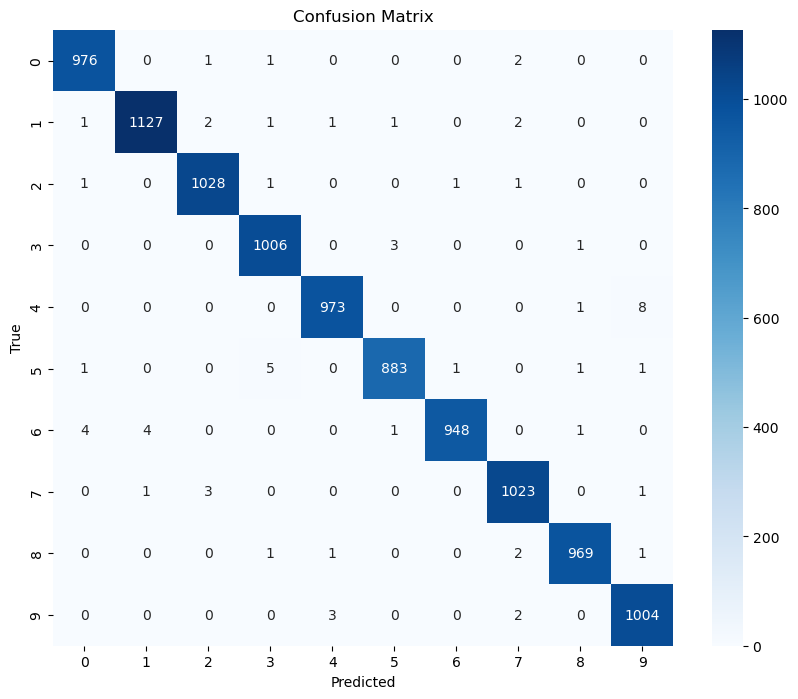

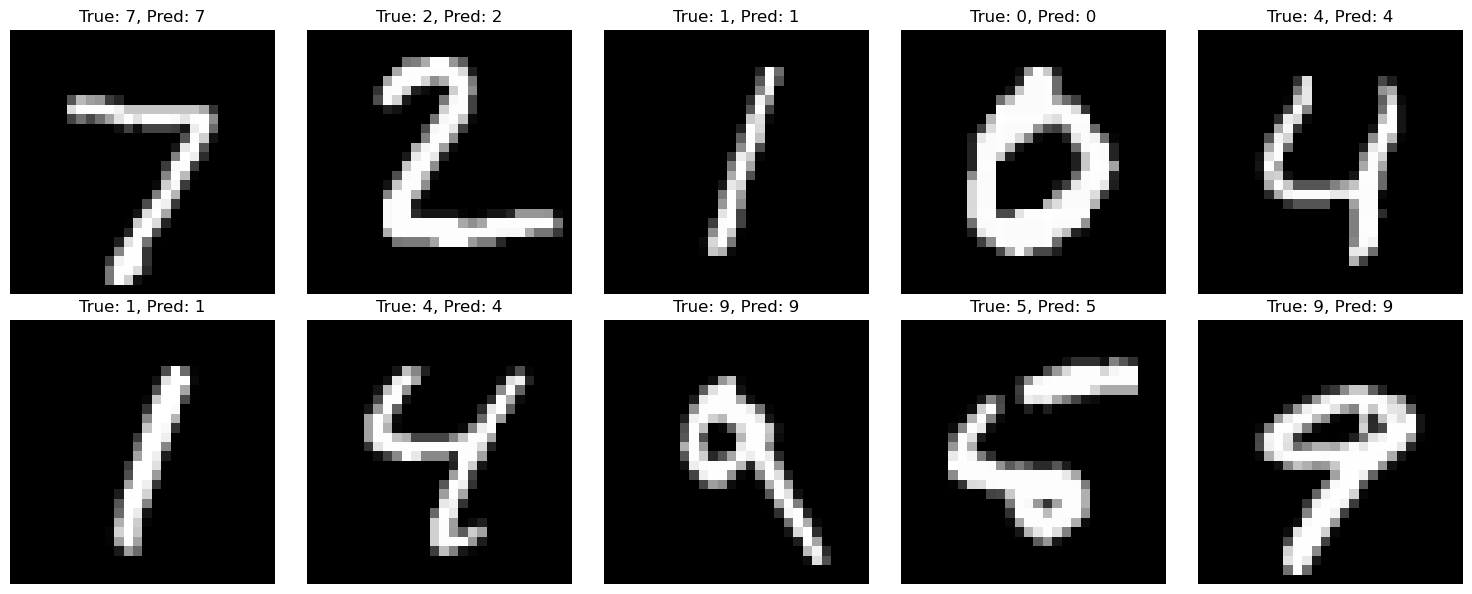

In [24]:
# Evaluate on test set
def evaluate_model(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = outputs.max(1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_preds), np.array(all_labels)

test_preds, test_labels = evaluate_model(final_model, final_test_loader, device)

# Calculate accuracy
test_accuracy = np.mean(test_preds == test_labels)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(test_labels, test_preds, target_names=[str(i) for i in range(10)]))

# Confusion matrix
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Show some correctly classified examples
correct_indices = np.where(test_preds == test_labels)[0][:10]

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, idx in enumerate(correct_indices):
    img, true_label = test_dataset[idx]
    pred_label = test_preds[idx]

    ax = axes[i//5, i%5]
    ax.imshow(img.squeeze(), cmap='gray')
    ax.set_title(f'True: {true_label}, Pred: {pred_label}')
    ax.axis('off')

plt.tight_layout()
plt.show()